In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [178]:
raw_data = pd.read_csv('data/tweets.csv', encoding='latin1')
raw_data.columns = ['text', 'product', 'target']
raw_data.dropna(subset=['text'], inplace=True)

In [179]:
from sklearn.model_selection import train_test_split
raw_X = raw_data['text']
raw_y = raw_data['target']
raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(raw_X, raw_y, random_state=112221, stratify=raw_y)

# Baseline Model

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

cv = CountVectorizer()
baseline_model = LogisticRegression(max_iter=1000, random_state=112221)

baseline_pipeline = Pipeline(steps=[('vectorizer', cv), ('baseline', baseline_model)])
baseline_pipeline.fit(raw_X_train, raw_y_train)

baseline_y_pred = baseline_pipeline.predict(raw_X_test)
accuracy_score(raw_y_test, baseline_y_pred)

0.677078750549934

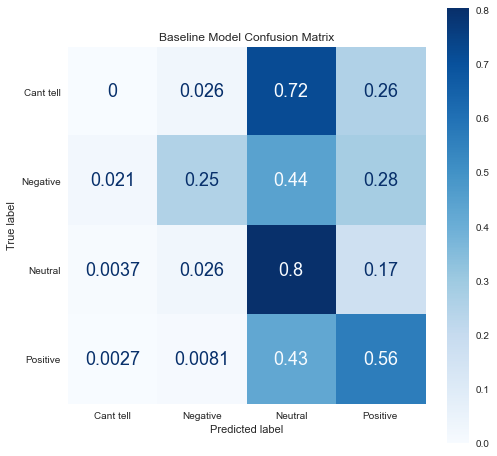

In [206]:
from sklearn.metrics import plot_confusion_matrix
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(baseline_pipeline, raw_X_test, raw_y_test, display_labels=['Cant tell', 'Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Blues')
plt.title('Baseline Model Confusion Matrix')
plt.grid(False)
plt.show()

# Preprocessed Data

In [6]:
clean_data = pd.read_csv('data/no_hashtags.csv')

In [110]:
apple_products = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
google_products = ['Google', 'Other Google product or service', 'Android App', 'Android']

clean_data['brand'] = clean_data['product'].apply(lambda x: 'google' if x in google_products else ('apple' if x in apple_products else 'unknown'))

In [7]:
clean_X = clean_data['text']
clean_y = clean_data['target']
clean_X_train, clean_X_test, clean_y_train, clean_y_test = train_test_split(clean_X, clean_y, random_state=112221, stratify=clean_y)

In [8]:
preprocessed_pipeline = Pipeline(steps=[('vectorizer', cv), ('baseline', baseline_model)])
preprocessed_pipeline.fit(clean_X_train, clean_y_train)

clean_y_pred = preprocessed_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, clean_y_pred)

0.6977463543968184

In [25]:
from sklearn.model_selection import GridSearchCV

lr_grid = {'baseline__C':[0.001, 0.1, 1], 'baseline__solver':['lbfgs', 'saga'], 'baseline__fit_intercept':[True, False]}
lr_gridsearch = GridSearchCV(estimator=baseline_pipeline, param_grid=lr_grid, scoring='accuracy', cv=5)
lr_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {lr_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {lr_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {lr_gridsearch.best_params_}')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear

Cross validation scores: [0.61102102 0.61102102 0.61293701 0.61293701 0.67717796 0.67717796
 0.67776651 0.67776651 0.68218434 0.68203707 0.67879408 0.67879408]
Best cross validation score: 68.22%
Optimal parameters: {'baseline__C': 1, 'baseline__fit_intercept': True, 'baseline__solver': 'lbfgs'}


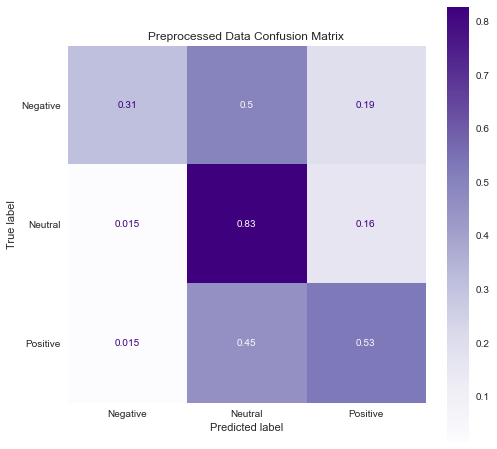

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(preprocessed_pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Purples')
plt.title('Preprocessed Data Confusion Matrix')
plt.grid(False)
plt.show()

# TF-IDF Vectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, ngram_range=(1,2))

tuned_pipeline = Pipeline(steps=[('tfidf', tfidf), ('baseline', baseline_model)])
tuned_pipeline.fit(clean_X_train, clean_y_train)

tuned_y_pred = tuned_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, tuned_y_pred)

0.7021652673442333

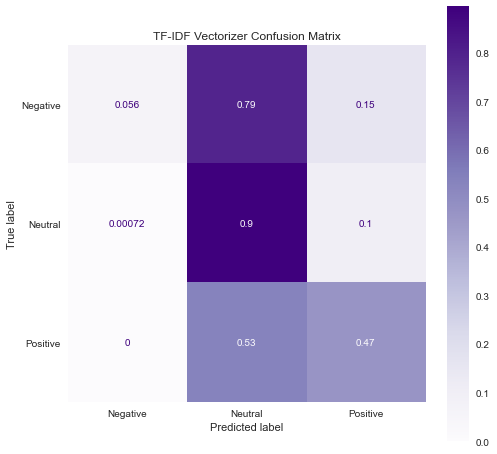

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Purples')
plt.title('TF-IDF Vectorizer Confusion Matrix')
plt.grid(False)
plt.show()

# Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=112221)

dt_pipeline = Pipeline(steps=[('tfidf', tfidf), ('dt', dt_model)])
dt_pipeline.fit(clean_X_train, clean_y_train)

dt_y_pred = dt_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, dt_y_pred)

0.6014140521431728

In [83]:
dt_grid = {
    'dt__criterion':['gini', 'entropy'],
    'dt__splitter':['best', 'random'],
    'dt__max_depth':[2, 6, 10, 15],
    'dt__min_samples_split': [5, 10],
    'dt__min_samples_leaf': [3, 6],
}

dt_gridsearch = GridSearchCV(estimator=dt_pipeline, param_grid=dt_grid, scoring='accuracy', cv=5)
dt_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {dt_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {dt_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {dt_gridsearch.best_params_}')

Cross validation scores: [0.61691355 0.61485268 0.61691355 0.61485268 0.61691355 0.61485268
 0.61691355 0.61485268 0.62693219 0.62708164 0.62752151 0.62811245
 0.62722739 0.62958586 0.62722739 0.62958586 0.62428134 0.63312351
 0.6236917  0.63253376 0.62442927 0.63636357 0.62442927 0.63636357
 0.62487218 0.6353309  0.62442992 0.63827836 0.61661911 0.62899567
 0.61661911 0.62899567 0.61720832 0.61441085 0.61720832 0.61441085
 0.61720832 0.61441085 0.61720832 0.61441085 0.62589996 0.62855244
 0.62589996 0.62634265 0.62663666 0.6289948  0.62663666 0.6289948
 0.62811028 0.62693295 0.62796268 0.63046897 0.62604789 0.63577262
 0.62604789 0.63577262 0.62236578 0.62885024 0.6220708  0.62958586
 0.61676747 0.63562578 0.61676747 0.63562578]
Best cross validation score: 63.83%
Optimal parameters: {'dt__criterion': 'gini', 'dt__max_depth': 15, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 10, 'dt__splitter': 'random'}


In [16]:
tuned_dt_model = DecisionTreeClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_dt_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_dt', tuned_dt_model)])
tuned_dt_pipeline.fit(clean_X_train, clean_y_train)

tuned_dt_y_pred = tuned_dt_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, tuned_dt_y_pred)

0.6283694211224039

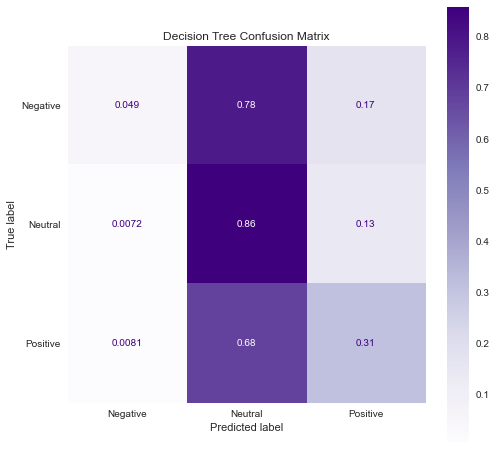

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_dt_pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Purples')
plt.title('Decision Tree Confusion Matrix')
plt.grid(False)
plt.show()

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [20]:
rf_model = RandomForestClassifier(random_state=112221)

rf_pipeline = Pipeline(steps=[('tfidf', tfidf), ('rf', rf_model)])
rf_pipeline.fit(clean_X_train, clean_y_train)

rf_y_pred = rf_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, rf_y_pred)

0.6836058329650906

In [88]:
rf_grid = {
    'rf__n_estimators':[10, 30, 100],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[None, 2, 6, 10],
    'rf__min_samples_split':[5, 10],
    'rf__min_samples_leaf':[3, 6]
}

rf_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_grid, scoring='accuracy', cv=5)
rf_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {rf_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {rf_gridsearch.best_params_}')

Cross validation scores: [0.65360293 0.66096854 0.66774712 0.65404649 0.6631793  0.66730551
 0.64211024 0.64314334 0.64093182 0.64211024 0.64314334 0.64093182
 0.6104317  0.60954761 0.60954761 0.6104317  0.60954761 0.60954761
 0.60998987 0.60954761 0.60954761 0.60998987 0.60954761 0.60954761
 0.613526   0.61352579 0.61131546 0.61323124 0.61352579 0.61161001
 0.61264224 0.61323124 0.61146285 0.61264224 0.61323124 0.61146285
 0.61470507 0.61529374 0.6154408  0.61514668 0.61514636 0.6154408
 0.61529396 0.61455704 0.61485137 0.61529396 0.61455704 0.61485137
 0.65095143 0.65831824 0.65979154 0.64933129 0.65802369 0.66141232
 0.63548209 0.63606923 0.63651149 0.63548209 0.63606923 0.63651149
 0.61013715 0.60954761 0.60954761 0.61013715 0.60954761 0.60954761
 0.61013715 0.60954761 0.60954761 0.61013715 0.60954761 0.60954761
 0.61382034 0.61205216 0.61102091 0.61440987 0.61219955 0.61087353
 0.61337829 0.61161001 0.61072647 0.61337829 0.61161001 0.61072647
 0.61558851 0.61573579 0.61470432 0.61

In [89]:
rf_tuned_grid = {
    'rf__max_depth': [None, 8, 12], 
    'rf__min_samples_leaf':[1, 2, 3], 
    'rf__min_samples_split': [10, 15], 
    'rf__n_estimators': [100, 150]
}

rf_tuned_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_tuned_grid, scoring='accuracy', cv=5)
rf_tuned_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {rf_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {rf_tuned_gridsearch.best_params_}')

Cross validation scores: [0.67982859 0.67968066 0.67702949 0.68218575 0.67614638 0.67806139
 0.67599899 0.6780615  0.66730551 0.67039916 0.66789494 0.66951508
 0.61337819 0.61367252 0.6139675  0.61381969 0.6132308  0.61352503
 0.6132308  0.61352503 0.61308342 0.61352503 0.61367274 0.61352503
 0.61706116 0.61720876 0.61706137 0.61661944 0.61632478 0.61632478
 0.61647205 0.61632478 0.61647205 0.61632478 0.61632467 0.61603001]
Best cross validation score: 68.22%
Optimal parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 15, 'rf__n_estimators': 150}


In [92]:
rf_tuned_grid_1 = {  
    'rf__min_samples_split': [15, 20, 25], 
    'rf__n_estimators': [150, 200, 300]
}

rf_tuned_gridsearch_1 = GridSearchCV(estimator=rf_pipeline, param_grid=rf_tuned_grid_1, scoring='accuracy', cv=5)
rf_tuned_gridsearch_1.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {rf_tuned_gridsearch_1.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_tuned_gridsearch_1.best_score_ :.2%}')
print(f'Optimal parameters: {rf_tuned_gridsearch_1.best_params_}')

Cross validation scores: [0.68218575 0.68189001 0.68159492 0.68365862 0.68085886 0.68233216
 0.68218543 0.68130178 0.68203848]
Best cross validation score: 68.37%
Optimal parameters: {'rf__min_samples_split': 20, 'rf__n_estimators': 150}


In [21]:
tuned_rf_model = RandomForestClassifier(min_samples_split=20, n_estimators=150, random_state=112221)

tuned_rf_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_rf', tuned_rf_model)])
tuned_rf_pipeline.fit(clean_X_train, clean_y_train)

tuned_rf_y_pred = tuned_rf_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, tuned_rf_y_pred)

0.6818382677861247

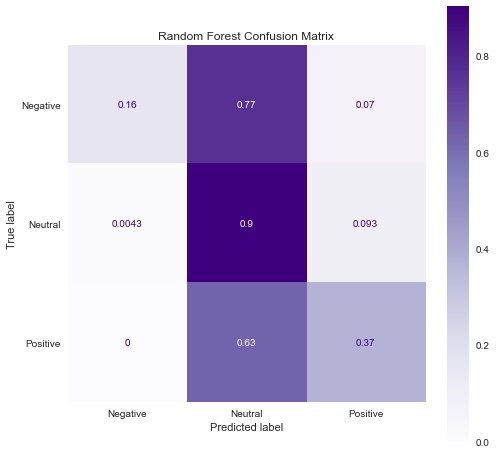

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_rf_pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Purples')
plt.title('Random Forest Confusion Matrix')
plt.grid(False)
plt.show()

# Extra Trees

In [23]:
et_model = ExtraTreesClassifier(random_state=112221)

et_pipeline = Pipeline(steps=[('tfidf', tfidf), ('et', et_model)])
et_pipeline.fit(clean_X_train, clean_y_train)

et_y_pred = rf_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, et_y_pred)

0.6836058329650906

In [96]:
et_grid = {
    'et__n_estimators':[10, 30, 100],
    'et__criterion':['gini', 'entropy'],
    'et__max_depth':[None, 2, 6, 10],
    'et__min_samples_split':[5, 10],
    'et__min_samples_leaf':[3, 6]
}

et_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_grid, scoring='accuracy', cv=5)
et_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {et_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_gridsearch.best_params_}')

Cross validation scores: [0.67143215 0.67216799 0.67585139 0.66848491 0.67378899 0.67703079
 0.64461359 0.64343669 0.64638383 0.64461359 0.64343669 0.64638383
 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761
 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761
 0.609695   0.61087353 0.60954761 0.609695   0.61013715 0.60954761
 0.61116775 0.61087342 0.60954761 0.61116775 0.61087342 0.60954761
 0.61308363 0.61455661 0.61440933 0.61278887 0.61411467 0.61485137
 0.61190424 0.61308309 0.61308353 0.61190424 0.61308309 0.61308353
 0.65728655 0.66553788 0.66391687 0.65875974 0.66671587 0.66715802
 0.6400473  0.63813239 0.63783806 0.6400473  0.63813239 0.63783806
 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761
 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761 0.60954761
 0.61205216 0.61131568 0.60954761 0.61190478 0.61131568 0.60954761
 0.6116099  0.61102037 0.609695   0.6116099  0.61102037 0.609695
 0.61426271 0.61352568 0.61367317 0.614

In [98]:
et_tuned_grid = {
    'et__n_estimators':[100, 150, 200],
    'et__min_samples_split':[10, 15],
    'et__min_samples_leaf':[1, 2, 3]
}

et_tuned_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_tuned_grid, scoring='accuracy', cv=5)
et_tuned_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {et_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_tuned_gridsearch.best_params_}')

Cross validation scores: [0.686754   0.68704812 0.68778504 0.68365927 0.68557558 0.68498561
 0.67894537 0.68056659 0.6793873  0.67806096 0.68056594 0.68041856
 0.67703079 0.67673591 0.67540978 0.67599845 0.67526218 0.67437831]
Best cross validation score: 68.78%
Optimal parameters: {'et__min_samples_leaf': 1, 'et__min_samples_split': 10, 'et__n_estimators': 200}


In [99]:
et_tuned_grid = {
    'et__n_estimators':[200, 250, 300],
    'et__min_samples_split':[10],
}

et_tuned_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_tuned_grid, scoring='accuracy', cv=5)
et_tuned_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {et_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_tuned_gridsearch.best_params_}')

Cross validation scores: [0.68778504 0.68572232 0.68793221]
Best cross validation score: 68.79%
Optimal parameters: {'et__min_samples_split': 10, 'et__n_estimators': 300}


In [100]:
et_tuned_grid_1 = {
    'et__n_estimators':[300, 400, 500],
    'et__min_samples_split':[10],
}

et_tuned_gridsearch_1 = GridSearchCV(estimator=et_pipeline, param_grid=et_tuned_grid_1, scoring='accuracy', cv=5)
et_tuned_gridsearch_1.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {et_tuned_gridsearch_1.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_tuned_gridsearch_1.best_score_ :.2%}')
print(f'Optimal parameters: {et_tuned_gridsearch_1.best_params_}')

Cross validation scores: [0.68793221 0.68660575 0.68645869]
Best cross validation score: 68.79%
Optimal parameters: {'et__min_samples_split': 10, 'et__n_estimators': 300}


In [24]:
tuned_et_model = ExtraTreesClassifier(min_samples_split=10, n_estimators=300, random_state=112221)

tuned_et_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_et_model)])
tuned_et_pipeline.fit(clean_X_train, clean_y_train)

tuned_et_y_pred = tuned_et_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, tuned_et_y_pred)

0.6809544851966416

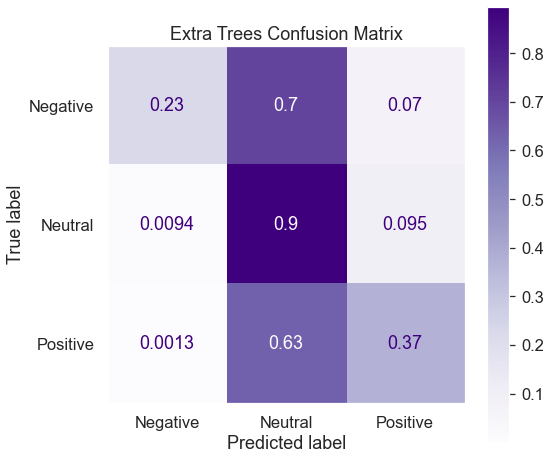

In [143]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_et_pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Greys')
plt.title('Extra Trees Confusion Matrix')
plt.grid(False)
plt.show()

# Gradient Boosting

In [26]:
gb_model = GradientBoostingClassifier(random_state=112221)

gb_pipeline = Pipeline(steps=[('tfidf', tfidf), ('gb', gb_model)])
gb_pipeline.fit(clean_X_train, clean_y_train)

gb_y_pred = gb_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, gb_y_pred)

0.6690234202386213

In [104]:
gb_grid = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators':[10, 30, 100],
    'gb__criterion':['friedman_mse', 'squared_error'],
    'gb__max_depth':[2, 6, 10],
    'gb__min_samples_split':[5, 10],
    'gb__min_samples_leaf':[3, 6]
}

gb_gridsearch = GridSearchCV(estimator=gb_pipeline, param_grid=gb_grid, scoring='accuracy', cv=5)
gb_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {gb_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {gb_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {gb_gridsearch.best_params_}')

Cross validation scores: [0.61912345 0.63459333 0.65566544 0.61912345 0.63459333 0.65581304
 0.61971255 0.6337099  0.65433974 0.61971255 0.6337099  0.65433974
 0.64240316 0.65743318 0.6752624  0.64137158 0.65875909 0.67938752
 0.64210915 0.65920135 0.67496687 0.64210915 0.65920135 0.67496687
 0.65271711 0.66612601 0.67909232 0.65080198 0.66598014 0.67717676
 0.65124392 0.66715704 0.67762087 0.65124392 0.66715704 0.67762087
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan    

In [ ]:
gb_tuned_grid = {
    'gb__loss': ['deviance'],
    'gb__n_estimators':[200, 300],
    'gb__criterion':['friedman_mse'],
    'gb__max_depth':[5, 6, 7],
    'gb__min_samples_split':[10, 15],
    'gb__min_samples_leaf':[1, 2, 3]
}

gb_tuned_gridsearch = GridSearchCV(estimator=gb_pipeline, param_grid=gb_tuned_grid, scoring='accuracy', cv=5)
gb_tuned_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {gb_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {gb_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {gb_tuned_gridsearch.best_params_}')

In [ ]:
'gb__criterion': 'friedman_mse', 'gb__loss': 'deviance', 'gb__max_depth': 6, 'gb__min_samples_leaf': 3, 'gb__min_samples_split': 10, 'gb__n_estimators': 100}

In [27]:
tuned_gb_model = GradientBoostingClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10, random_state=112221)

tuned_gb_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_gb_model)])
tuned_gb_pipeline.fit(clean_X_train, clean_y_train)

tuned_gb_y_pred = tuned_gb_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, tuned_gb_y_pred)

0.6787450287229342

# Stochastic Gradient Descent

In [28]:
from sklearn.linear_model import SGDClassifier

In [66]:
sgd_model = SGDClassifier(random_state=1127)

sgd_pipeline = Pipeline(steps=[('tfidf', tfidf), ('sgd', sgd_model)])
sgd_pipeline.fit(clean_X_train, clean_y_train)

sgd_y_pred = sgd_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, sgd_y_pred)

0.7140963323022537

In [147]:
%store -r metric_table

In [151]:
z = {'Name': 'SGD', 'Accuracy': 0.7140963323022537}
metric_table = metric_table.append(z, ignore_index = True).drop(11).reset_index(drop=True)

In [152]:
metric_table

,Name,Accuracy
0,Baseline Model,0.677079
1,Preprocessed Data,0.697746
2,TF-IDF Vectorizer,0.706142
3,Decision Tree,0.613787
4,Tuned Decision Tree,0.641184
5,Random Forest,0.681838
6,Tuned Random Forest,0.683164
7,Extra Trees,0.681838
8,Tuned Extra Trees,0.692444
9,Gradient Boosting,0.669907


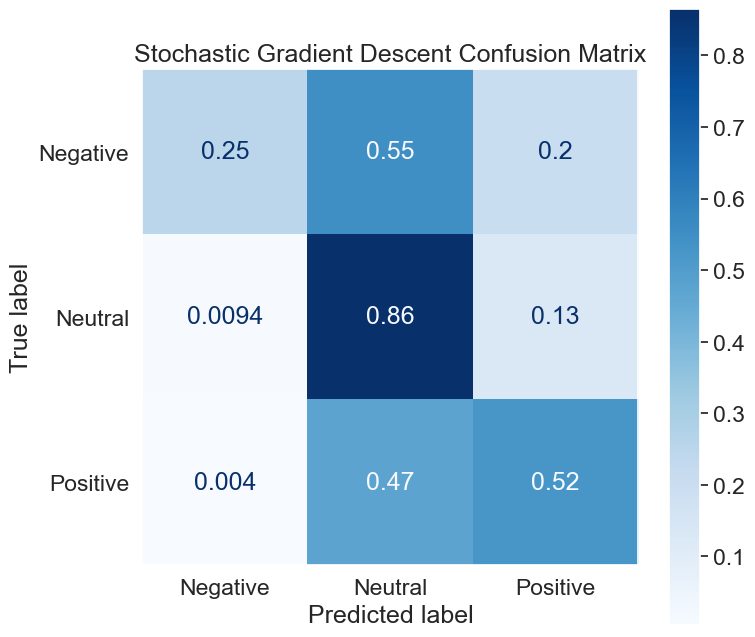

In [267]:
sns.set_theme(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd_pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Blues')
plt.title('Stochastic Gradient Descent Confusion Matrix')
plt.grid(False)
plt.show()

In [38]:
from sklearn.model_selection import GridSearchCV
sgd_grid = {
    'sgd__penalty':['elasticnet'],
    'sgd__l1_ratio':[0.15],
    'sgd__fit_intercept':[True],
    'sgd__max_iter':[200, 1000, 1500]
}

sgd_gridsearch = GridSearchCV(estimator=sgd_pipeline, param_grid=sgd_grid, scoring='accuracy', cv=5)
sgd_gridsearch.fit(clean_X_train, clean_y_train)

print(f'Cross validation scores: {sgd_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {sgd_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {sgd_gridsearch.best_params_}')

Cross validation scores: [0.68778385 0.68778385 0.68778385]
Best cross validation score: 68.78%
Optimal parameters: {'sgd__fit_intercept': True, 'sgd__l1_ratio': 0.15, 'sgd__max_iter': 200, 'sgd__penalty': 'elasticnet'}


In [74]:
tuned_sgd_model = SGDClassifier(penalty='elasticnet', l1_ratio=0.15, max_iter=200, random_state=1127)

tuned_sgd_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_sgd_model)])
tuned_sgd_pipeline.fit(clean_X_train, clean_y_train)

tuned_sgd_y_pred = tuned_sgd_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, tuned_sgd_y_pred)

0.7127706584180291

In [153]:
y = {'Name': 'Tuned SGD', 'Accuracy': 0.7140963323022537}
metric_table = metric_table.append(y, ignore_index = True)

In [154]:
metric_table

,Name,Accuracy
0,Baseline Model,0.677079
1,Preprocessed Data,0.697746
2,TF-IDF Vectorizer,0.706142
3,Decision Tree,0.613787
4,Tuned Decision Tree,0.641184
5,Random Forest,0.681838
6,Tuned Random Forest,0.683164
7,Extra Trees,0.681838
8,Tuned Extra Trees,0.692444
9,Gradient Boosting,0.669907


In [164]:
a = {'Name': 'Neural Network', 'Accuracy': 0.64}
metric_table = metric_table.append(a, ignore_index = True)

In [165]:
b = {'Name': 'Tuned Neural Network', 'Accuracy': 0.67}
metric_table = metric_table.append(b, ignore_index = True)

In [166]:
metric_table

,Name,Accuracy
0,Baseline Model,0.677079
1,Preprocessed Data,0.697746
2,TF-IDF Vectorizer,0.706142
3,Decision Tree,0.613787
4,Tuned Decision Tree,0.641184
5,Random Forest,0.681838
6,Tuned Random Forest,0.683164
7,Extra Trees,0.681838
8,Tuned Extra Trees,0.692444
9,Gradient Boosting,0.669907


In [167]:
metric_table.drop(13).reset_index(drop=True)

,Name,Accuracy
0,Baseline Model,0.677079
1,Preprocessed Data,0.697746
2,TF-IDF Vectorizer,0.706142
3,Decision Tree,0.613787
4,Tuned Decision Tree,0.641184
5,Random Forest,0.681838
6,Tuned Random Forest,0.683164
7,Extra Trees,0.681838
8,Tuned Extra Trees,0.692444
9,Gradient Boosting,0.669907


In [168]:
final_table = metric_table.copy()

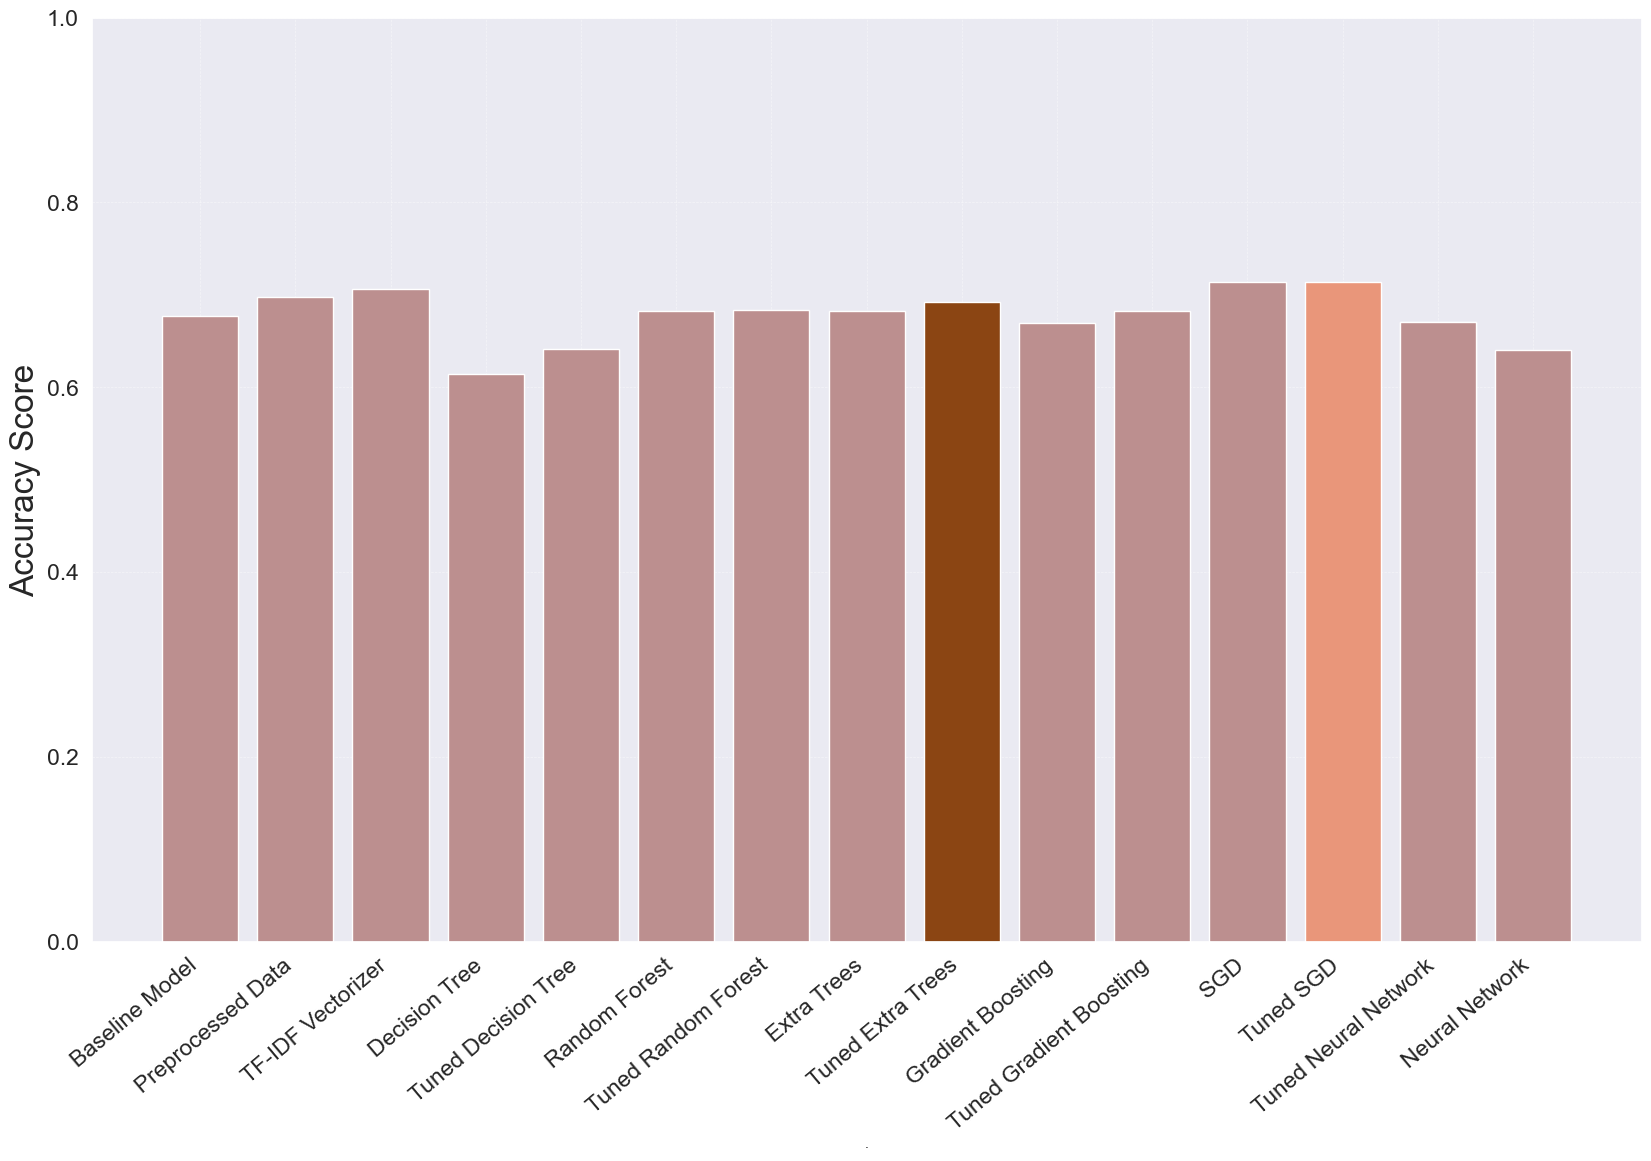

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.5)
fig, ax = plt.subplots(figsize=(20, 12))

c = ['rosybrown', 'rosybrown', 'rosybrown', 'rosybrown', 
     'rosybrown', 'rosybrown', 'rosybrown', 'rosybrown', 'saddlebrown', 
     'rosybrown', 'rosybrown', 'rosybrown', 'darksalmon', 'rosybrown', 'rosybrown',]

plt.bar(metric_table['Name'], metric_table['Accuracy'], color=c)

#ax.set_title('Model Improvements', fontsize=20)

ax.set_xlabel('.', fontsize=10)
plt.xticks(rotation=40, ha='right')
plt.ylim(0, 1)
ax.set_ylabel('Accuracy Score', fontsize=24)

plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

plt.show()

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', lowercase=False)

tuned_pipeline = Pipeline(steps=[('tfidf', tfidf), ('baseline', baseline_model)])
tuned_pipeline.fit(clean_X_train, clean_y_train)

tuned_y_pred = tuned_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, tuned_y_pred)

0.7061422889969068

In [86]:
from sklearn.inspection import permutation_importance
result = permutation_importance(tuned_pipeline.fit(clean_X_train, clean_y_train), clean_X_test, clean_y_test, n_repeats=30, random_state=20211122)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=clean_X_test.columns[sorted_idx])

ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

IndexError: tuple index out of range

In [79]:
len(clean_y_test)

2263

In [89]:
positive_df = clean_data.loc[clean_data['target']==2]
negative_df = clean_data.loc[clean_data['target']==0]

In [92]:
positive_df['clean'].str.contains('ipad').sum()

41

In [93]:
negative_df['clean'].str.contains('ipad').sum()

9

In [94]:
positive_df['clean'].str.contains('design').sum()

57

In [95]:
negative_df['clean'].str.contains('design').sum()

28

In [96]:
positive_df['clean'].str.contains('iphone').sum()

2

In [98]:
negative_df['clean'].str.contains('iphone').sum()

3

In [99]:
positive_df['clean'].str.contains('marissa').sum()

71

In [100]:
negative_df['clean'].str.contains('marissa').sum()

6

In [101]:
positive_df['clean'].str.contains('fascist').sum()

0

In [102]:
negative_df['clean'].str.contains('fascist').sum()

14

In [103]:
positive_df['clean'].str.contains('battery').sum()

12

In [104]:
negative_df['clean'].str.contains('battery').sum()

20

In [111]:
positive_df_apple = clean_data.loc[(clean_data['target']==2)& (clean_data['brand']=='apple')]
negative_df_apple = clean_data.loc[(clean_data['target']==0) &(clean_data['brand']=='apple')]

positive_df_google = clean_data.loc[(clean_data['target']==2)& (clean_data['brand']=='google')]
negative_df_google = clean_data.loc[(clean_data['target']==0) &(clean_data['brand']=='google')]

In [112]:
positive_df_apple['clean'].str.contains('ipad').sum()

37

In [113]:
negative_df_apple['clean'].str.contains('ipad').sum()

7

In [114]:
positive_df_apple['clean'].str.contains('design').sum()

44

In [115]:
negative_df_apple['clean'].str.contains('design').sum()

23

In [118]:
positive_df_apple['clean'].str.contains('iphone').sum()

1

In [119]:
negative_df_apple['clean'].str.contains('iphone').sum()

3

In [120]:
positive_df_apple['clean'].str.contains('happy').sum()

15

In [121]:
positive_df_google['clean'].str.contains('happy').sum()

9

In [122]:
positive_df_apple['clean'].str.contains('great').sum()

75

In [123]:
positive_df_google['clean'].str.contains('great').sum()

50

In [124]:
positive_df['clean'].str.contains('crowded').sum()

0

In [125]:
negative_df['clean'].str.contains('crowded').sum()

4

In [126]:
positive_df_apple['clean'].str.contains('fast').sum()

16

In [127]:
positive_df_google['clean'].str.contains('fast').sum()

16

In [128]:
positive_df_google['clean'].str.contains('android').sum()

139

In [129]:
negative_df_google['clean'].str.contains('android').sum()

16

In [130]:
positive_df_google['clean'].str.contains('map').sum()

87

In [131]:
negative_df_google['clean'].str.contains('map').sum()

10

In [132]:
positive_df_google['clean'].str.contains('iphone').sum()

1

In [133]:
negative_df_google['clean'].str.contains('iphone').sum()

0

In [134]:
positive_df_apple['clean'].str.contains('line').sum()

135

In [135]:
negative_df_apple['clean'].str.contains('line').sum()

18

In [137]:
positive_df_google['clean'].str.contains('fascist').sum()

0

In [139]:
negative_df_google['clean'].str.contains('fascist').sum()

0

In [170]:
positive_df['clean'].str.contains('map').sum()

106

In [171]:
negative_df['clean'].str.contains('map').sum()

10